# Plotting the MNIST results

## All imports for running the code

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
import pandas as pd
import numpy as np
from numpy.ma import masked_array

## Defining functions for plotting

In [97]:
mapper = {
    'memorization': 0,
    'grokking': 1,
    'comprehension': 2,
    'confusion': 3
}
inv_mapper = {v: k for k, v in mapper.items()}


def load_diagram(path, max_iters=10**5):
    results = pd.read_csv(path, index_col='wd')
    # results = results.reindex(sorted(results.columns, key=lambda x: float(x)), axis=1)
    # results = results.sort_index()
    
    train_iters = results.copy()
    train_iters = train_iters.applymap(lambda x: int(x.split(',')[0][1:]))

    test_iters = results.copy()
    test_iters = test_iters.applymap(lambda x: int(x.split(',')[1][:-1]))

    value = test_iters.max()
    train_iters = train_iters.replace(0, value=value)
    test_iters = test_iters.applymap(lambda x: x if x < max_iters else np.nan)
    
    iter_diff = np.where(np.isnan(test_iters), train_iters, test_iters - train_iters)
    phases = iter_diff.copy() < 1e+3

    # 0 - convergence on both train and test, diff > 1k (grokking)
    # 1 - convergence on both train and test, diff < 1k (comprehension)
    # 2 - no test convergence, train converges (didn't reach max iter) (memorization)
    # 3 - no test and train convergence, (confusion)
    phases = np.where(np.isnan(test_iters),  (train_iters == value) + 2, phases.astype(int))

    # convert to 0 - memorization, 1 - grokking, 2 - comprehension, 3 - confusion
    mapper = {0: 1, 1: 2, 2: 0, 3: 3}
    for i in range(phases.shape[0]):
        for j in range(phases.shape[1]):
            phases[i, j] = mapper[phases[i, j]]
    
    phases = pd.DataFrame(data=phases, index=results.index, columns=results.columns)
    
    return phases, train_iters, test_iters

In [98]:
def plot_diagram(ax, data, ticksize=16, labelsize=20, legend=True, x_label=True, y_label=True,
                 xtick_freq=2, ytick_freq=2, y_label_format='{:.2e}'):
    cmap = matplotlib.colors.ListedColormap(['darkslateblue', 'gold', 'yellowgreen', 'black'])
    ax.imshow(np.array(data), cmap=cmap)

    if x_label:
        xlabels = data.columns[::xtick_freq]
        xlabels = ['{:.2e}'.format(float(x)) for x in xlabels]
        ax.set_xticks(np.arange(len(data.columns))[::xtick_freq], labels=xlabels, rotation=-45, size=ticksize)
        ax.set_xlabel('learning rate', size=labelsize)
    else:
        ax.set_xticks([])

    if y_label:
        ylabels = data.index[::ytick_freq]
        ylabels = [y_label_format.format(float(x)) for x in ylabels]
        ax.set_yticks(np.arange(len(data.index))[::ytick_freq], labels=ylabels, rotation=0, size=ticksize)
        ax.set_ylabel('weight decay', size=labelsize)
    else:
        ax.set_yticks([])

    if legend:
        values = np.unique(np.array(data))
        colors = [cmap(value) for value in values]

        # create a patch (proxy artist) for every color 
        patches = [[
            mpatches.Patch(color=colors[i], label=f""),
            mpatches.Patch(color='none', label=f"{inv_mapper[i]}")
        ] for i in range(len(values))]
        patches = [x for a in patches for x in a]

        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, borderaxespad=0.5, fontsize=18, loc='center left', bbox_to_anchor=(1, 0.5),
                  fancybox=True, shadow=True, ncol=1, handlelength=2, handletextpad=-2)

In [99]:
def plot_smooth_diagram(ax, fig, data, train, test, x_label=True, y_label=True,
                        xtick_freq=2, ytick_freq=2, thr_pos=0.5):
    iter_diff = np.where(np.isnan(test), train, test - train)

    data_np = np.array(data)    
    result = np.copy(data_np)
    result = (result + 1) % 4
    tmp = np.log10(np.array(train_iters))
    tmp = 1 - (tmp - np.nanmin(tmp)) / (np.nanmax(tmp) - np.nanmin(tmp)) * 0.6
    result = np.where(data_np == 0, tmp, result)

    tmp = np.log10(np.array(test_iters - train_iters) + 10)
    tmp[np.isnan(test_iters)] = None
    tmp = 3 - (tmp - np.nanmin(tmp)) / (np.nanmax(tmp) - np.nanmin(tmp))
    result = np.where((data_np == 1) | (data_np == 2), tmp, result)

    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list(
        "cmap1", ['black', 'darkslateblue']
    )
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list(
        "cmap2", ['gold', 'green']
    )

    if x_label:
        xlabels = data.columns[::xtick_freq]
        xlabels = ['{:.2e}'.format(float(x)) for x in xlabels]
        ax.set_xticks(np.arange(len(data.columns))[::xtick_freq], labels=xlabels, rotation=-45, size=16)
        ax.set_xlabel('learning rate', size=20)
    else:
        ax.set_xticks([])

    if y_label:
        ylabels = data.index[::ytick_freq]
        ylabels = ['{}'.format(float(x)) for x in ylabels]
        ax.set_yticks(np.arange(len(data.index))[::ytick_freq], labels=ylabels, rotation=0, size=16)
        ax.set_ylabel('weight decay', size=20)
    else:
        ax.set_yticks([])

    res1 = masked_array(result, result > 1)
    cm1 = ax.imshow(res1, cmap=cmap1)

    res2 = masked_array(result - 2, result <= 1)
    cm2 = ax.imshow(res2, cmap=cmap2)
    
    labels1 = np.append(np.arange(0.5, 5.1, 0.5), 5 + np.log10(3))
    arr = np.log10(np.array(train_iters + 1))
    minval, maxval = np.nanmin(arr), np.nanmax(arr)
    ticks1 = 1 - (labels1 - minval) / (maxval - minval) * 1

    labels2 = np.arange(1, 5.1, 0.5)
    arr = np.log10(np.array(test_iters - train_iters + 5))
    minval, maxval = np.nanmin(arr), np.nanmax(arr)
    ticks2 = 1 - (labels2 - minval) / (maxval - minval)

    cbar1 = fig.colorbar(cm1, shrink=0.9, pad=0.1, ticks=ticks1)
    cbar2 = fig.colorbar(cm2, shrink=0.9, pad=0.2, ticks=ticks2)

    cbar2.ax.plot([0, 1], [1 - (3 - minval) / (maxval - minval)] * 2, 'r')
    cbar2.ax.text(-2.5, thr_pos, 'grokking\nthreshold', ha='center', va='center', fontsize=14)

    cbar1.ax.set_title('train\nconv iter', fontsize=16)
    cbar1.ax.text(-2, -0.105, 'memorization\n& confusion', fontsize=14)
    cbar1.ax.set_yticklabels(['$10^{' + f'{label:.1f}' + '}$' for label in labels1[:-2]] + 2 * ['>$1.5 \cdot 10^{5.0}$'],
                             fontsize=16)
    cbar2.ax.set_title('valid conv iter — \ntrain conv iter', fontsize=16)
    cbar2.ax.text(-2.8, -0.15, 'comprehension\n& grokking', fontsize=14)
    cbar2.ax.set_yticklabels(['$10^{' + f'{label:.1f}' + '}$' for label in labels2], fontsize=16)

## Discrete phase diagram for the original setup

In [103]:
discrete_phases, _, _ = load_diagram('mnist_results/results_original.csv', max_iters=10**5)

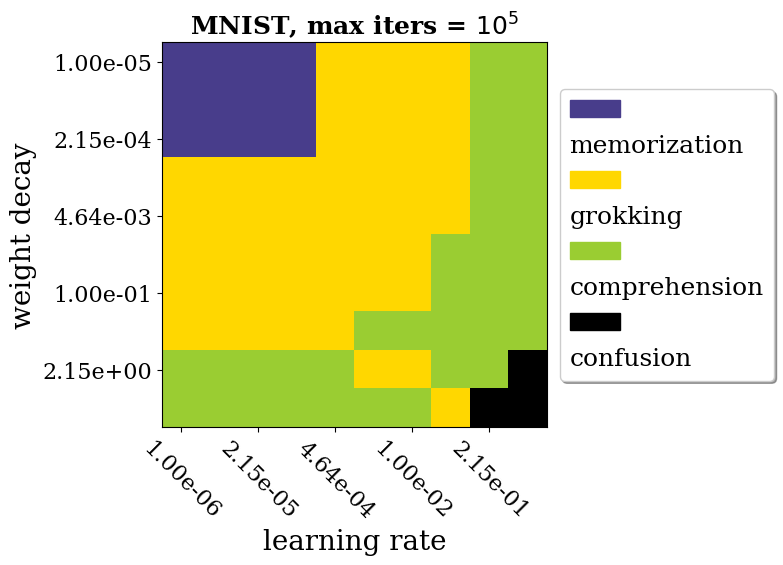

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

plot_diagram(ax, discrete_phases, legend=True)

ax.set_title('MNIST, max iters = $10^5$', fontsize=18, weight='bold')

plt.show()

## Smooth phase diagrams

In [105]:
discrete_phases, _, _ = load_diagram('mnist_results/results_extended.csv', max_iters=10**5)
smooth_phases, train_iters, test_iters = load_diagram('mnist_results/results_extended.csv', max_iters=1.5 * 10**5)

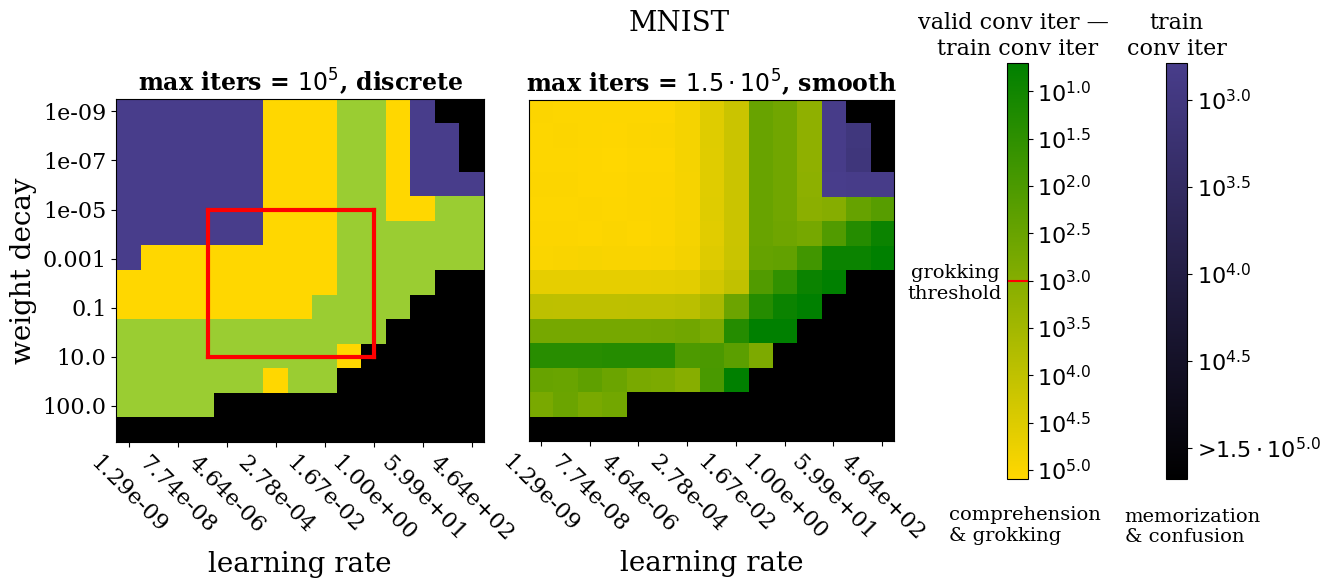

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios':[1, 2.04]})

plot_diagram(axs[0], discrete_phases, legend=False, y_label_format='{}')
plot_smooth_diagram(axs[1], fig, smooth_phases, train_iters, test_iters,
                    y_label=False, thr_pos=0.47)

axs[0].plot([3.25, 10], [10, 10], c='r', linewidth=3)
axs[0].plot([3.25, 10], [4, 4], c='r', linewidth=3)
axs[0].plot([3.25, 3.25], [4, 10], c='r', linewidth=3)
axs[0].plot([10, 10], [4, 10], c='r', linewidth=3)

axs[0].set_title('max iters = $10^5$, discrete', fontsize=17, fontweight='bold')
axs[1].set_title('max iters = $1.5 \cdot 10^5$, smooth', fontsize=17, fontweight='bold')

plt.suptitle('MNIST', y=0.93, size=20)
plt.subplots_adjust(wspace=0.08)

## Convergence on training dataset

In [107]:
def plot_heatmap(ax, data, ticksize=16, labelsize=20, legend=True, x_label=True, y_label=True,
                 xtick_freq=2, ytick_freq=2):

    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list(
        "cmap1", ['black', 'black']
    )

    if x_label:
        xlabels = data.columns[::xtick_freq]
        xlabels = ['{:.2e}'.format(float(x)) for x in xlabels]
        ax.set_xticks(np.arange(len(data.columns))[::xtick_freq], labels=xlabels, rotation=-45, size=16)
        ax.set_xlabel('learning rate', size=20)
    else:
        ax.set_xticks([])

    if y_label:
        ylabels = data.index[::ytick_freq]
        ylabels = ['{}'.format(float(x)) for x in ylabels]
        ax.set_yticks(np.arange(len(data.index))[::ytick_freq], labels=ylabels, rotation=0, size=16)
        ax.set_ylabel('weight decay', size=20)
    else:
        ax.set_yticks([])

    cm1 = plt.imshow(result, cmap='hot')
    cm2 = plt.imshow(np.where(np.isnan(result), 1.5 * 1e+5, np.nan), cmap=cmap1)

    labels1 = np.arange(1, 5.1, 0.5)
    arr = np.log10(np.array(train_iters))
    minval, maxval = np.nanmin(arr), np.nanmax(arr)
    ticks1 = 1 - (labels1 - minval) / (maxval - minval) * 1

    cbar1 = fig.colorbar(cm1, shrink=0.8, pad=0.09, ticks=ticks1)
    cbar1.ax.set_title('train\nconv iter', fontsize=16)
    cbar1.ax.set_yticklabels(['$10^{' + f'{label:.1f}' + '}$' for label in labels1[:-1]] + ['>$10^{5.0}$'], fontsize=16)

    plt.text(16.9, 13, '- $\infty$', horizontalalignment='left',
         verticalalignment='center', size=18)

In [108]:
smooth_phases, train_iters, test_iters = load_diagram('mnist_results/results_extended.csv', max_iters=1.5 * 10**5)
train_iters = train_iters.replace(1.5 * 10**5, np.nan)

train_convergence = np.log10(np.array(train_iters))
train_convergence = 1 - (train_convergence - np.nanmin(train_convergence)) \
                    / (np.nanmax(train_convergence) - np.nanmin(train_convergence)) * 0.6
train_convergence = pd.DataFrame(data=train_convergence, index=smooth_phases.index, columns=smooth_phases.columns)

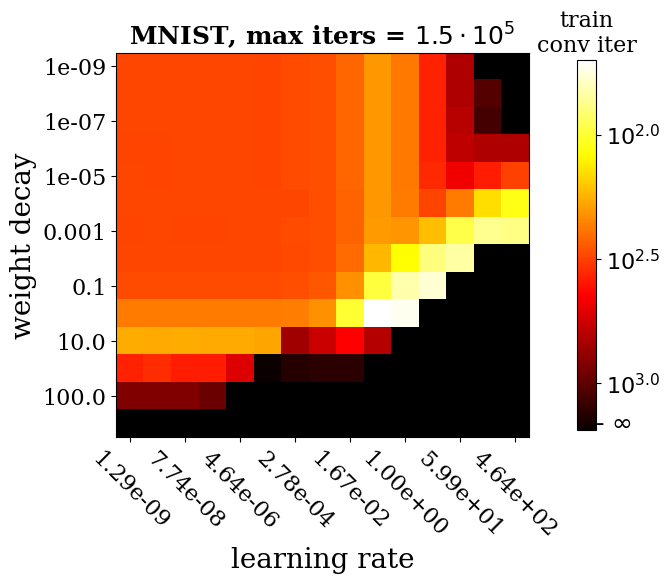

In [109]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

plot_heatmap(ax, train_convergence, legend=True)

ax.set_title('MNIST, max iters = $1.5 \cdot 10^5$', size=18, weight='bold')

plt.show()

### Plotting accuracy trajectiories from training process for strange memorization area (wd = 1e-7, lr = 50)

In [ ]:
from mnist_run import train_model

wd = 1e-7
lr = 50

(
    phase,
    (train_converge_step, test_converge_step),
    (train_accuracies, test_accuracies)
) = train_model(wd=wd, lr=lr, early_stop=False)

In [14]:
np.save('train_accs.npy', train_accuracies)
np.save('test_accs.npy', test_accuracies)

In [ ]:
train_accuracies = np.load('train_accs.npy')
test_accuracies = np.load('test_accs.npy')

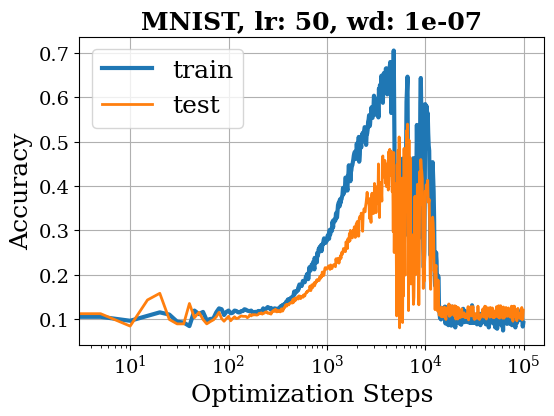

In [19]:
plt.figure(figsize=(6, 4))

log_steps = np.unique([int(step) for step in np.logspace(0, np.log10(1e+5), 1000) / 5])[:len(train_accuracies)] * 5
plt.plot(log_steps, train_accuracies, label='train', linewidth=3)
plt.plot(log_steps, test_accuracies, label='test', linewidth=2)

plt.xscale('log')

plt.title(f'MNIST, lr: {lr}, wd: {wd}', weight='bold', size=18)
plt.ylabel('Accuracy', size=18)
plt.xlabel('Optimization Steps', size=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)
plt.grid()
plt.show()